Исаев А.М. ПР 5 - АЗСИИ

Пулим lime


In [ ]:
!git clone https://github.com/marcotcr/lime.git

Cloning into 'lime'...


Устанавливаем lime

In [ ]:
!pip install lime

Выполняем импорт требуемых библиотек

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images

Загружаем датасет MNIST, преобразуем каждое изображение в цветное для корректной работы lime - Ррезультаты преобразования сохраняем в массиыв X_vec,  y_vec, содержащий соответствующие метки (цифры от 0 до 9) для каждого изображения.

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
# сделаем каждое изображение цветным, чтобы lime_image работал корректно
X_vec = np.stack([gray2rgb(iimg) for iimg in mnist.data.values.astype(np.uint8).reshape((-1, 28, 28))],0).astype(np.uint8)
y_vec = mnist.target.astype(np.uint8)

Визуализируем первую цифру из MNIST

Text(0.5, 1.0, 'Digit: 5')

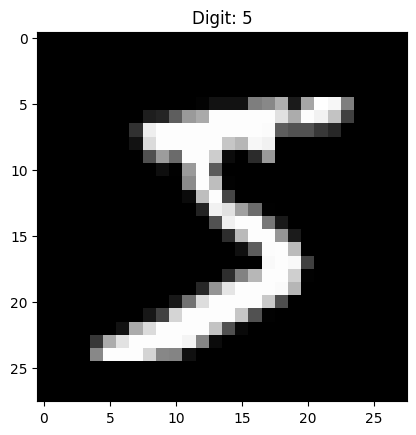

In [ ]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.imshow(X_vec[0], interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_vec[0]))

**Создаем конвеер(pipeline)**
Собственно сам он нужен для обработки изображений

In [ ]:

#Этот код создаёт конвейер для обработки изображений, который превращает изображения в одномерные векторы и затем использует классификатор RandomForest для их анализа.
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

class PipeStep(object):
    """
    Эта обёртка позволяет использовать функции внутри конвейера обработки данных без необходимости их обучения или подгонки (fitting).
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    #('Normalize', Normalizer()),
    #('PCA', PCA(16)),
    ('RF', RandomForestClassifier())
                              ])

Разделяем данные на обучающие и test наборы, 55 % - для обучения 45 % - тестирование

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.55)

In [ ]:
simple_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x0000021480D20970>),
                ('Flatten Image',
                 <__main__.PipeStep object at 0x0000021480D20A90>),
                ('RF', RandomForestClassifier())])

%load_ext autoreload и %autoreload 2 позволяют перезагрузить модули Python при их изменении, после импортируем lime

In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # при ненахождении пути
    import lime

Создаём объекты для объяснения работы модели на изображениях с помощью библиотеки Lime

In [ ]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

Измеряем время с помощью которого сможем анализировать работу классификатора

In [ ]:
%%time
explanation = explainer.explain_instance(X_test[0],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: total: 9.95 s
Wall time: 11.1 s


Визуализируем объяснения из Lime - В первом изображении показаны только положительные области, которые влияют на определение данной метки. Во втором изображении показаны и положительные, и отрицательные области, влияющие на классификацию данной метки.

Text(0.5, 1.0, 'Positive/Negative Regions for 5')

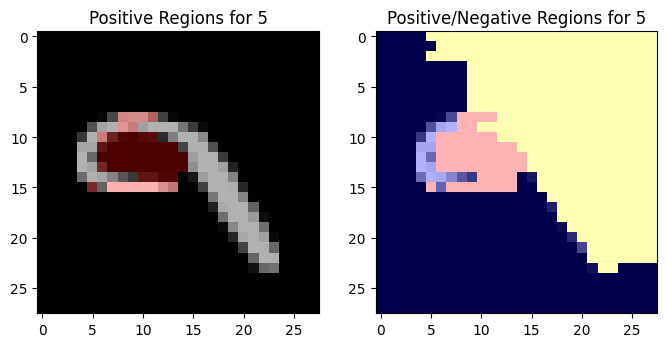

In [ ]:
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[0]))
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[0]))

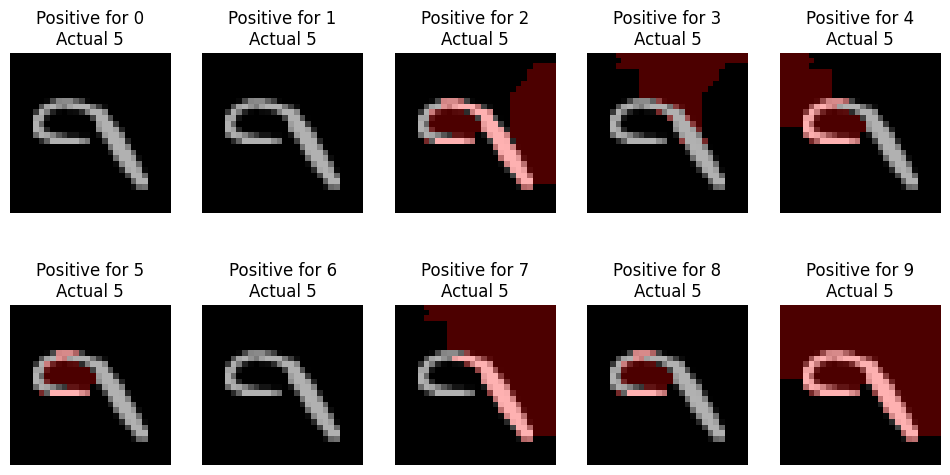

In [ ]:
# отображаем влияние каждого класса на классификацию конкретного изображения
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,X_test[0], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[0]))
    c_ax.axis('off')

Выбираем один из неправильно предсказанных образцов тестового набора данных, используя предсказания, сделанные модельным конвейером simple_rf_pipeline, таким образом идентифицируем случаи совершения ошибки в предсказаниях

In [ ]:
pipe_pred_test = simple_rf_pipeline.predict(X_test)
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])
print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test[wrong_idx], pipe_pred_test[wrong_idx]))

Using #27581 where the label was 9 and the pipeline predicted 5


Анализируем это конкретное изображение, используя те же параметры, что и ранее

In [ ]:
%%time
explanation = explainer.explain_instance(X_test[wrong_idx],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: total: 10.5 s
Wall time: 11.4 s


Таким образом в конечном итоге было выявлено как модель классификации обрабатывает и интерпретирует изображения из набора данных MNIST, а также какие области изображений оказывают наибольшее влияние на ее предсказания для различных классов.

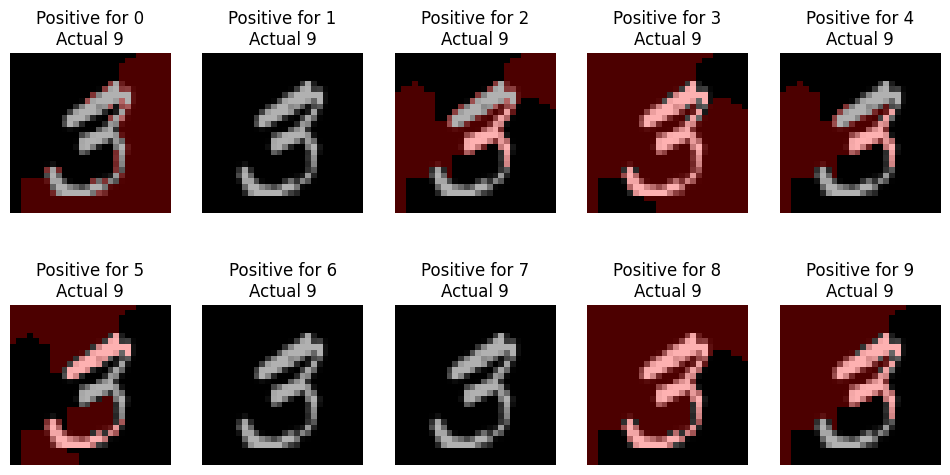

In [ ]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[wrong_idx]))
    c_ax.axis('off')